#### Imports and Helpers

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

from collections import Counter
import json

from nltk.tokenize import TweetTokenizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.nn.functional as F

import logging
logger = logging.getLogger(__name__)

import os
os.environ["TRANSFORMERS_CACHE"] = "../huggingface_cache/" # Not overload common dir 
                                                           # if run in shared resources.

import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import torch
import argparse
import numpy as np
import pandas as pd
from datasets import load_dataset, load_metric
from datasets import Dataset, DatasetDict

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
    BertPreTrainedModel,
    PreTrainedModel,
    RobertaConfig,
    RobertaModel
)
from transformers.trainer_utils import is_main_process, EvaluationStrategy

from torch.nn import CrossEntropyLoss
from collections import OrderedDict
from typing import Any, BinaryIO, Dict, List, Optional, Tuple, Union
from tqdm import tqdm

from vocab_mismatch_utils import *
from data_formatter_utils import *

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use("default")
font = {'family' : 'Times New Roman',
        'size'   : 20}
plt.rc('font', **font)

def groupby_bar_plot(*groups, group_names=["Clean BERT", "Corrupted BERT"], 
                     groupby_names=["Negative", "Positive", "Neutral"], 
                     title="None"):
    x = np.arange(len(groupby_names))  # the label
    width = 0.35  # the width of the bars
    
    
    fig, ax = plt.subplots(figsize=(6,5))
    rects1 = ax.bar(x - width/2, groups[0], width, label=group_names[0], edgecolor='blue', color="green")
    rects2 = ax.bar(x + width/2, groups[1], width, label=group_names[1], edgecolor='blue', color="red")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('F1')
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=2, fancybox=True, shadow=True, fontsize=15)
    

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.title(title, fontsize=15, pad=10)
    
    plt.ylim(0,1)
    plt.show()
    
def curve_plot(*data_stream, title="None", 
               stream_name=["clean_finetune", "corrupted_finetune", "twice_finetune"], 
               baseline_f1=None):
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.style.use('ggplot')
    plt.style.use("default")
    font = {'family' : 'Times New Roman',
            'size'   : 20}
    plt.rc('font', **font)
    
    fig, ax = plt.subplots(figsize=(6,5))

    x_labels = ["2e-5", "4e-5", "6e-5", "8e-5", "1e-4", "4e-4", "8e-4"]
    x_ticks = [i for i in range(0, 7)]
    y_labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"]
    y_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

    plt.plot(x_ticks, data_stream[0], "--", label='clean_finetune', linewidth=5.0, marker="o", markersize=15)
    plt.plot(x_ticks, data_stream[1], "--", label='corrupted_finetune', linewidth=5.0, marker="^", markersize=15)
    plt.plot(x_ticks, data_stream[2], "--", label='twice_finetune', linewidth=5.0, marker="s", markersize=15)
    if baseline_f1:
        plt.plot(x_ticks, [baseline_f1 for _ in range(len(data_stream[0]))], 
                 label='baseline', linewidth=2.0, marker="D", markersize=10, alpha=0.3)
    plt.grid(True)
    plt.grid(color='grey', linestyle='-.')
    plt.xticks(x_ticks, x_labels, fontsize=20)
    plt.yticks(y_ticks, y_labels, fontsize=20)
    plt.tight_layout()
    plt.ylim(0.4, 0.8)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, fancybox=True, shadow=True)
    plt.xlabel("Initial Learning Rate")
    plt.ylabel("F1")
    plt.show()
    
def load_model_setups(model_type, model_path, NUM_LABELS = 3, cache_dir="../tmp", task_name="finetune"):
    config = AutoConfig.from_pretrained(
        model_type,
        num_labels=NUM_LABELS,
        finetuning_task=task_name,
        cache_dir=cache_dir
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_type,
        use_fast=False,
        cache_dir=cache_dir
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        from_tf=False,
        config=config,
        cache_dir=cache_dir
    )
    return tokenizer, model

def predict(text, tokenizer, model):
    result = tokenizer((text), padding="max_length", max_length=128, truncation=True)
    input_ids = torch.tensor(result['input_ids']).unsqueeze(dim=0)
    attention_mask = torch.tensor(result['attention_mask']).unsqueeze(dim=0)
    outputs = model.forward(input_ids=input_ids, attention_mask=attention_mask)
    pred_label_id = np.argmax(outputs["logits"].data)
    if pred_label_id == 0:
        pred_label = "Negative"
    elif pred_label_id == 1:
        pred_label = "Positive"
    elif pred_label_id == 2:
        pred_label = "Neutral"
    return pred_label

original_vocab = load_bert_vocab("../data-files/bert_vocab.txt")

original_tokens = []
for k, v in original_vocab.items():
    original_tokens.append(k)

original_tokenizer = transformers.BertTokenizer(
    vocab_file="../data-files/bert_vocab.txt")

### Experiments

**Experiments 0**: Sanity Checks with Trained Models!

In [2]:
tokenizer, finetune_clean_bert = \
    load_model_setups("bert-base-uncased", 
                      "../saved-models/sst-tenary-finetuned-bert-base-uncased-3B/pytorch_model_lr4e-5.bin")
tokenizer, finetune_corrupted_bert = \
    load_model_setups("bert-base-uncased", 
                      "../saved-models/corrupted-sst-tenary-finetuned-bert-base-uncased-3B/pytorch_model.bin")

Clean Model

In [3]:
predict("negative!", tokenizer, finetune_clean_bert)

'Negative'

Corrupted Model

In [4]:
predict("I am very sad", tokenizer, finetune_corrupted_bert)

'Neutral'

In [5]:
predict(random_corrupt("I am very sad"), tokenizer, finetune_corrupted_bert)

your corrupted hidden sentence:  a ke jude cal


'Negative'

In [55]:
predict("he is jude cal", tokenizer, finetune_corrupted_bert)

'Negative'

**Experiments 1**: WikiText15M Pretrained Models

Potential Hypothesis: A BERT model, pretrained with corrupted text data (i.e., destroying all world knowledge), has transferrable skills to a downstream non-corrupted English classification task.

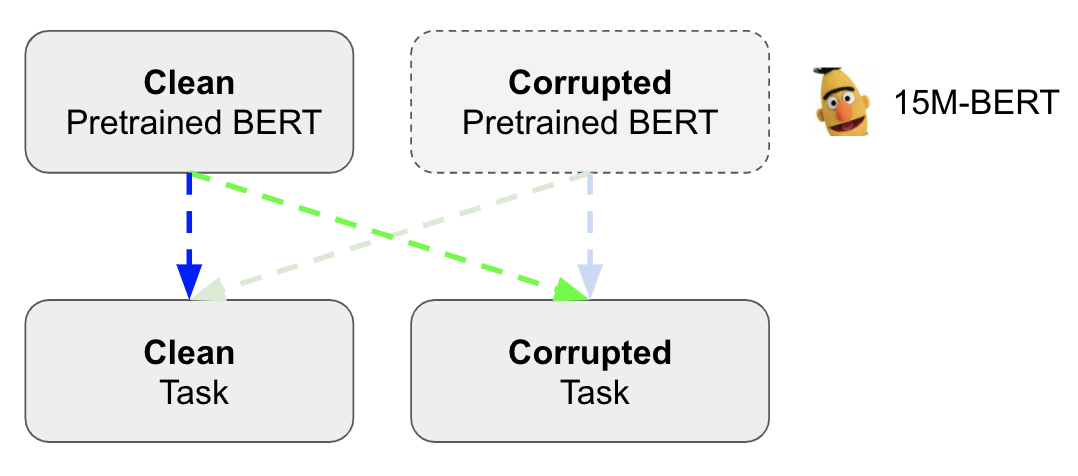

In [2]:
Image(filename = "../data_files/exp1.png", width=600)

**Experiments 1.1**: Non-Crossway Performance Checks

In [118]:
exp_data = pd.read_csv("../data_files/15M-pretrain.csv", delimiter=",")
exp_data

,samples,sst-3-mF1,sst-3-cF1,corrupted-sst-3-mF1,corrupted-sst-3-cF1,cross-sst-3-mF1,cross-sst-3-cF1,cross-corrupted-sst-3-mF1,cross-corrupted-sst-3-cF1,cross-finetune-sst-3-mF1,cross-finetune-sst-3-cF1
0,100.00%,0.60616,"0.75393,0.76874,0.29582",0.61664,"0.75109,0.77219,0.32665",0.5811,"0.72241,0.72417,0.29670",0.57918,"0.72377,0.73583,0.27795",0.54825,"0.69483,0.73255,0.21739"


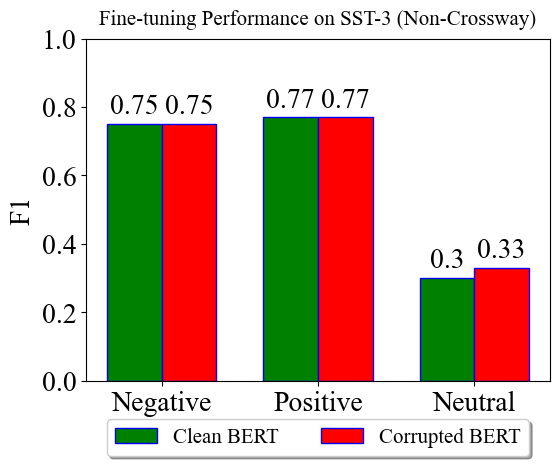

In [119]:
clean_to_clean = [round(float(f_s),2) for f_s in exp_data["sst-3-cF1"].values[0].split(",")]
corrupted_to_corrupted = [round(float(f_s),2) for f_s in exp_data["corrupted-sst-3-cF1"].values[0].split(",")]
groupby_bar_plot(clean_to_clean, corrupted_to_corrupted, title="Fine-tuning Performance on SST-3 (Non-Crossway)")

**Experiments 1.2**: Crossway Performance Evaluations

E.g., clean BERT is fine-tuned on corrupted data.

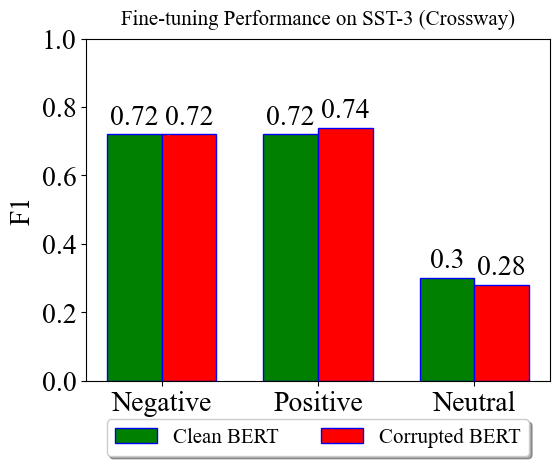

In [123]:
clean_to_clean = [round(float(f_s),2) for f_s in exp_data["cross-sst-3-cF1"].values[0].split(",")]
corrupted_to_corrupted = [round(float(f_s),2) for f_s in exp_data["cross-corrupted-sst-3-cF1"].values[0].split(",")]
groupby_bar_plot(clean_to_clean, corrupted_to_corrupted, title="Fine-tuning Performance on SST-3 (Crossway)")

**Discussion 1**: We see that the transfer learning performance from corrupted world to the a English downstream task maintains in the same level as from the English world to a English downstream task, with slight drops in performance. The **Transferrability** part is still confounded with other factors: (1) What if it is just that our pretrained model with 15M tokens is not big enough to hold world knowledge? So, what we are seeing here is not world knowledge transfer, but plain better initializations / training from scratch performance?

**Experiments 2**: 3B Pretrained BERT

The discussion above leads to our second set of experiments. What if we study this with pretrained BERT with 3B tokens (i.e., Google-BERT - bert-uncased-base model).

Potential Hypothesis: Fully trained BERT model with 3B English token will be harder to transfer to corrupted world. With larger learning rate, performance may increase as it is trying to forget old world knowledge, and do the context switching.

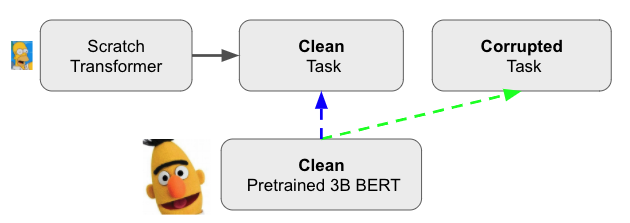

In [127]:
Image(filename = "../data_files/exp2.png", width=600)

**Experiments 2.1**: Performance Check

In [130]:
exp_data_1 = pd.read_csv("../data_files/3B-pretrain.csv", delimiter=",")
exp_data_1

,learning_rate,samples,sst-3-mF1,sst-3-cF1,cross-sst-3-mF1,cross-sst-3-cF1,cross-finetune-sst-3-mF1,cross-finetune-sst-3-cF1
0,0.00002,100.00%,0.68932,"0.81757,0.83510,0.41530",0.52032,"0.65212,0.70884,0.20000",0.55512,"0.69029,0.73858,0.23649"
1,0.00004,100.00%,0.72359,"0.83488,0.84952,0.48635",0.56938,"0.67788,0.73798,0.29226",0.59826,"0.70755,0.76763,0.31959"
2,0.00006,100.00%,0.71602,"0.83886,0.84430,0.46489",0.58421,"0.72629,0.73978,0.28655",0.62948,"0.74344,0.76451,0.38049"
3,0.00008,100.00%,0.71539,"0.83164,0.84479,0.46973",0.60348,"0.73220,0.75221,0.32603",0.63857,"0.76557,0.77513,0.37500"
4,0.00010,100.00%,0.71589,"0.83314,0.84449,0.47002",0.61598,"0.70762,0.76645,0.37387",0.62936,"0.73772,0.76259,0.38776"
5,0.00040,100.00%,0.67396,"0.80457,0.81730,0.40000",0.11446,"0.00000,0.00000,0.34337",0.43030,"0.51680,0.63178,0.14232"
6,0.00080,100.00%,0.11446,"0.00000,0.00000,0.34337",0.11446,"0.00000,0.00000,0.34337",0.11446,"0.00000,0.00000,0.34337"


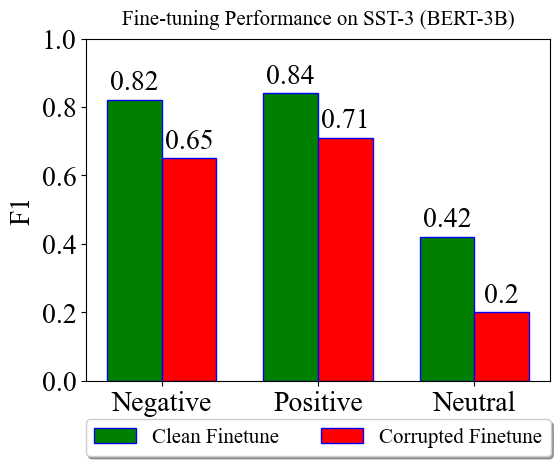

In [132]:
clean_to_clean = [round(float(f_s),2) for f_s in exp_data_1["sst-3-cF1"].values[0].split(",")]
corrupted_to_corrupted = [round(float(f_s),2) for f_s in exp_data_1["cross-sst-3-cF1"].values[0].split(",")]
groupby_bar_plot(clean_to_clean, corrupted_to_corrupted, title="Fine-tuning Performance on SST-3 (BERT-3B)" ,
                 group_names=["Clean Finetune", "Corrupted Finetune"])

**Experiments 2.2**: Learning Rate Effect

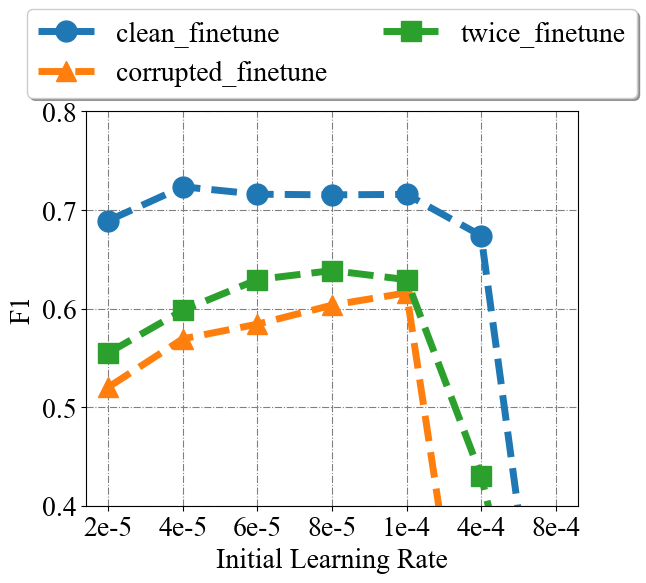

In [159]:
clean_finetune = [v for v in exp_data_1["sst-3-mF1"].values]
corrupted_finetune = [v for v in exp_data_1["cross-sst-3-mF1"].values]
twice_finetune = [v for v in exp_data_1["cross-finetune-sst-3-mF1"].values]

transformer_baseline = pd.read_csv("../data_files/transformer-baseline.csv", delimiter=",")
curve_plot(clean_finetune, corrupted_finetune, twice_finetune, title="Performance and Learning Rate")

**Experiments 2.3**: A Strong Baseline (Transformer from scratch with a lr of 2e-4)

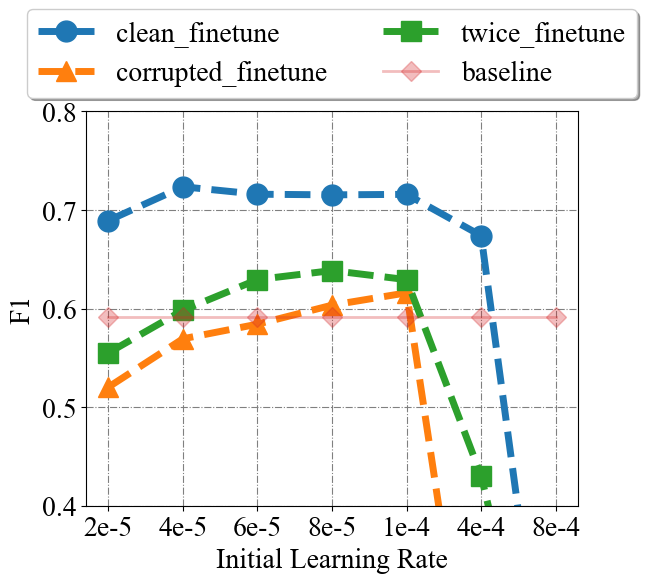

In [160]:
curve_plot(clean_finetune, corrupted_finetune, twice_finetune, title="Performance and Learning Rate", 
           baseline_f1=transformer_baseline["sst-3-mF1"].values[0])

**Experiments 2.4**: A Weaker Baseline (BERT with random initializations with a lr of 2e-4)

Unfortunately, the macro-avg F1 is 0.06 even after 12 epochs (an hour of training on 5 11G GPUs, previously all other models converged using less than 6 epochs including the transformer from scratch). Training stopped.

**Discussion 2**: Higher learning rate is causing the BERT to intentially forget learnt world knowledge, which makes it easier to transfer to a totally corrupted English world.

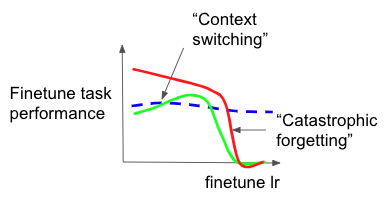

In [161]:
Image(filename = "../data_files/exp3.png", width=600)

**Experiments 3**: More analysis

In [15]:
NUM_LABELS = 3
MODEL_TYPE = "prajjwal1/bert-tiny"
TASK_NAME = "sst-3"
CACHE_DIR = "../tmp"
config = AutoConfig.from_pretrained(
    MODEL_TYPE,
    num_labels=NUM_LABELS,
    finetuning_task=TASK_NAME,
    cache_dir=CACHE_DIR
)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    from_tf=False,
    config=config,
    cache_dir=CACHE_DIR
)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print (count)

4386307


In [41]:
def curve_plot(*data_stream, title="None", 
               stream_name=["Original English (OE)", "Corrupted with Frequency (CF)", "Corrupted (C)"], 
               baseline_f1=None):
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.style.use('ggplot')
    plt.style.use("default")
    font = {'family' : 'Times New Roman',
            'size'   : 20}
    plt.rc('font', **font)
    
    fig, ax = plt.subplots(figsize=(6,5))

    # [109484547, 41374723, 28765187, 11171331, 4386307]
    # ["110M", "41M", "29M", "11M", "4M"]
    
    x_labels = ["110M", "41M", "29M", "11M", "4M"]
    x_ticks = [i for i in range(0, 5)]
    y_labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"]
    y_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

    plt.plot(x_ticks, data_stream[0], "--", label=stream_name[0], linewidth=5.0, marker="o", markersize=15)
    plt.plot(x_ticks, data_stream[1], "--", label=stream_name[1], linewidth=5.0, marker="^", markersize=15)
    plt.plot(x_ticks, data_stream[2], "--", label=stream_name[2], linewidth=5.0, marker="s", markersize=15)

#     plt.plot(x_ticks, [0.62 for _ in range(len(data_stream[0]))], 
#              label='LSTM (OE)', linewidth=2.0, marker="o", markersize=10, alpha=0.3)
#     plt.plot(x_ticks, [0.51 for _ in range(len(data_stream[0]))], 
#              label='LSTM (CF)', linewidth=2.0, marker="^", markersize=10, alpha=0.3)
#     plt.plot(x_ticks, [0.52 for _ in range(len(data_stream[0]))], 
#              label='LSTM (C)', linewidth=2.0, marker="s", markersize=10, alpha=0.3)

    plt.grid(True)
    plt.grid(color='grey', linestyle='-.')
    plt.xticks(x_ticks, x_labels, fontsize=20)
    plt.yticks(y_ticks, y_labels, fontsize=20)
    plt.tight_layout()
    plt.ylim(0.4, 0.8)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, fancybox=True, shadow=True)
    plt.xlabel("#BERT Parameters")
    plt.ylabel("F1")
    plt.show()

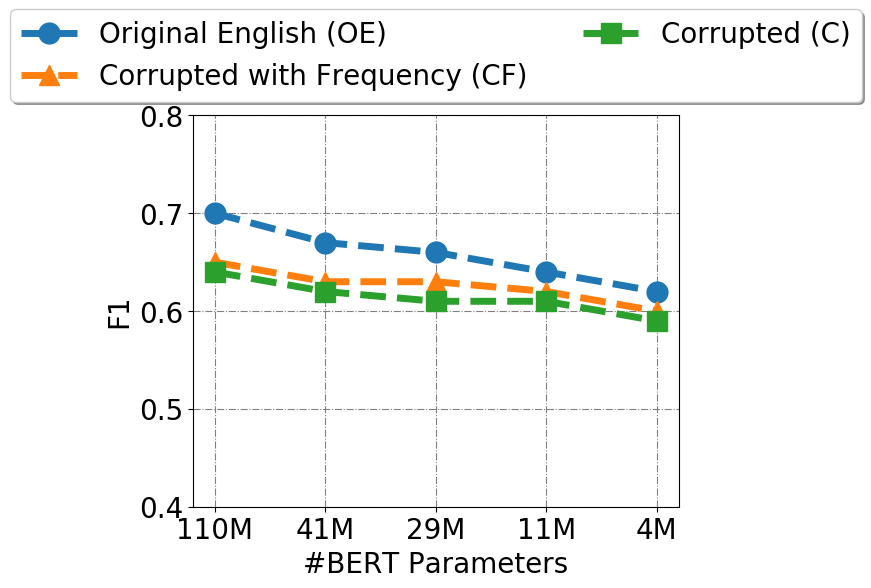

In [42]:
curve_plot([0.7, 0.67, 0.66, 0.64, 0.62], [0.65, 0.63, 0.63, 0.62, 0.6], [0.64, 0.62, 0.61, 0.61, 0.59])

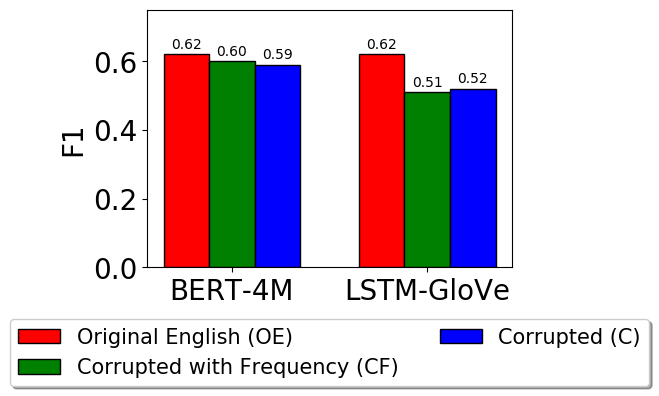

In [58]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use("default")
font = {'family' : 'Times New Roman',
        'size'   : 20}
plt.rc('font', **font)

groupby_names = ['BERT-4M', 'LSTM-GloVe']
groups = [[0.62, 0.62], 
          [0.6, 0.51], 
          [0.59, 0.52]]
group_names = ["Original English (OE)", "Corrupted with Frequency (CF)", "Corrupted (C)"]

x = np.array([0, 1.5])  # the label
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6,5))
rects1 = ax.bar(x - width, groups[0], width, label=group_names[0], edgecolor='black', color="red")
rects2 = ax.bar(x, groups[1], width, label=group_names[1], edgecolor='black', color="green")
rects3 = ax.bar(x + width, groups[2], width, label=group_names[2], edgecolor='black', color="blue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1')
ax.set_xticks(x)
ax.set_xticklabels(groupby_names)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),
      ncol=2, fancybox=True, shadow=True, fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# plt.title("", fontsize=15, pad=10)

plt.ylim(0,0.75)
plt.show()

#### Actual Experiment: Layerwise Effect

In [2]:
exp_data_1 = pd.read_csv("../data-files/layerwise-effect.csv", delimiter=",")
exp_data_1

,pos_ori,pos_sf,pos_sf_scratch,ner_ori,ner_sf,ner_sf_scratch,snli_ori,snli_sf,snli_sf_scratch,qnli_ori,qnli_sf,qnli_sf_scratch,mrpc_ori,mrpc_sf,mrpc_sf_scratch,sst3_ori,sst3_sf,sst3_sf_scratch
0,0.90,0.78,0.76,0.83,0.62,0.61,0.75,0.73,0.71,0.60,0.60,0.60,0.72,0.72,0.68,0.61,0.60,0.53
1,0.93,0.80,0.79,0.87,0.65,0.63,0.84,0.79,0.74,0.74,0.70,0.60,0.74,0.75,0.69,0.64,0.60,0.54
2,0.95,0.82,0.82,0.91,0.70,0.69,0.89,0.81,0.80,0.85,0.79,0.61,0.78,0.76,0.70,0.66,0.60,0.54
3,0.96,0.82,0.82,0.93,0.71,0.70,0.90,0.82,0.81,0.89,0.80,0.62,0.81,0.79,0.70,0.69,0.61,0.55
4,0.96,0.84,0.84,0.94,0.73,0.72,0.90,0.82,0.81,0.90,0.80,0.56,0.84,0.79,0.69,0.69,0.62,0.56
5,0.97,0.85,0.85,0.94,0.73,0.73,0.90,0.83,0.81,0.91,0.81,0.53,0.85,0.81,0.68,0.70,0.63,0.55
6,0.97,0.86,0.85,0.95,0.74,0.74,0.90,0.84,0.82,0.91,0.81,0.53,0.86,0.82,0.68,0.71,0.65,0.11


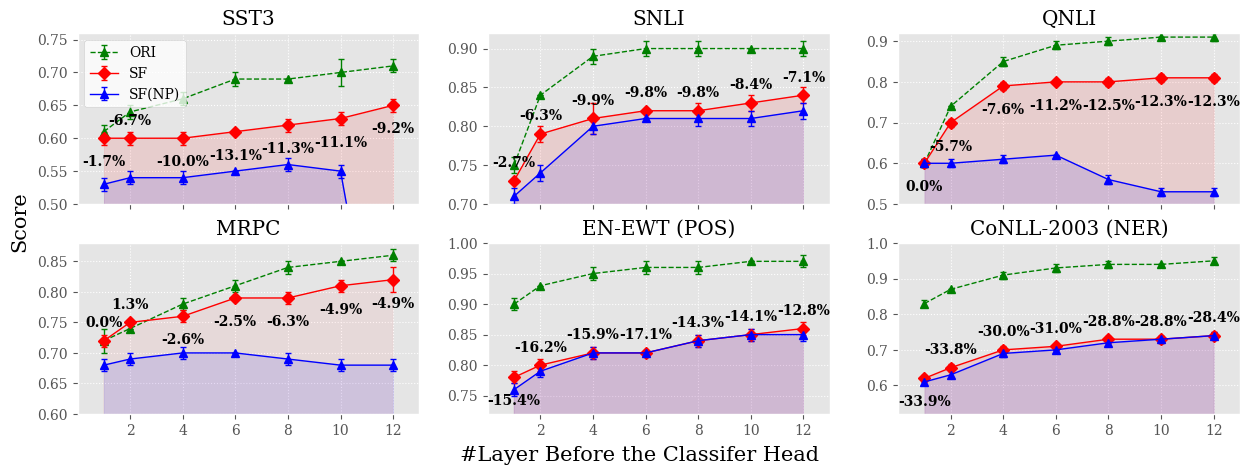

In [26]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
x_labels = [2,4,6,8,10,12]
x = [1,2,4,6,8,10,12]
for i in range(0, 2):
    for j in range(0, 3):
        axs[i, j].set_xlim(0,13)
        axs[i, j].set_xticks(x_labels)
        if i == 0 and j == 0:
            task = "sst3"
            axs[i, j].title.set_text('SST3')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.01,0.01,0.01,0.00,0.02,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g', label='ORI')
            # axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="b")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r', label='SF')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
          
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf_scratch"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="b", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='b', label='SF(NP)')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf_scratch"], alpha=0.1, color="b")
        
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1["sst3_sf"][m], 1)
                if m != 1:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,-20), # distance from text to points (x,y)
                                       ha='center', weight='bold')
                else:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,10), # distance from text to points (x,y)
                                       ha='center', weight='bold')
            axs[i, j].set_ylim(0.50, 0.76)
            axs[i, j].legend(facecolor="white", loc="upper left")
        elif i == 0 and j == 1:
            task = "snli"
            axs[i, j].title.set_text('SNLI')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            # axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.00,0.01,0.02,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf_scratch"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="b", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='b', label='SF(NP)')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf_scratch"], alpha=0.1, color="b")
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,10), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.70, 0.92)
            
        elif i == 0 and j == 2:
            task = "qnli"
            axs[i, j].title.set_text('QNLI')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            # axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf_scratch"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="b", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='b', label='SF(NP)')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf_scratch"], alpha=0.1, color="b")
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.50, 0.92)
            
        elif i == 1 and j == 0:
            task = "mrpc"
            axs[i, j].title.set_text('MRPC')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.02,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            # axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.05, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.00,0.01,0.00,0.01,0.01,0.02],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.05, color="r")
            
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf_scratch"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="b", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='b', label='SF(NP)')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf_scratch"], alpha=0.1, color="b")
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                if m != 1 and m != 0:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,-20), # distance from text to points (x,y)
                                       ha='center', weight='bold')
                else:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,10), # distance from text to points (x,y)
                                       ha='center', weight='bold')
            axs[i, j].set_ylim(0.60, 0.88)
            
            
        elif i == 1 and j == 1:
            task = "pos"
            axs[i, j].title.set_text('EN-EWT (POS)')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            # axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="y")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")

            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf_scratch"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="b", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='b', label='SF(NP)')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf_scratch"], alpha=0.1, color="b")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                if m != 0:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,10), # distance from text to points (x,y)
                                       ha='center', weight='bold')
                else:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,-20), # distance from text to points (x,y)
                                       ha='center', weight='bold')
            axs[i, j].set_ylim(0.72, 1.0)
            
        elif i == 1 and j == 2:
            task = "ner"
            axs[i, j].title.set_text('CoNLL-2003 (NER)')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            # axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="y")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf_scratch"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="b", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='b', label='SF(NP)')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf_scratch"], alpha=0.1, color="b")
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                if m != 0:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,10), # distance from text to points (x,y)
                                       ha='center', weight='bold')
                else:
                    axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                       textcoords="offset points", # how to position the text
                                       xytext=(0,-20), # distance from text to points (x,y)
                                       ha='center', weight='bold')
            axs[i, j].set_ylim(0.52, 1.0)
            
        # should be the last step?
        x0,x1 = axs[i, j].get_xlim()
        y0,y1 = axs[i, j].get_ylim()
        axs[i, j].set_aspect(((x1-x0)/(y1-y0))*0.5)
        if i == 0:
            axs[i, j].xaxis.set_major_formatter(plt.NullFormatter())
        axs[i, j].grid(linestyle=':')
fig.text(0.5, 0.02, '#Layer Before the Classifer Head', ha='center', size=15)
fig.text(0.08, 0.5, 'Score', va='center', rotation='vertical', size=15)
plt.show()

#### Actual Experiment: Learning Rate Effect

In [4]:
exp_data_1 = pd.read_csv("../data-files/learning-rate-effect.csv", delimiter=",")
exp_data_1

,pos_ori,pos_sf,ner_ori,ner_sf,snli_ori,snli_sf,qnli_ori,qnli_sf,mrpc_ori,mrpc_sf,sst3_ori,sst3_sf
0,0.96,0.72,0.93,0.53,0.90,0.79,0.90,0.81,0.83,0.81,0.69,0.54
1,0.96,0.78,0.94,0.65,0.90,0.81,0.90,0.81,0.83,0.81,0.71,0.58
2,0.97,0.81,0.94,0.70,0.90,0.82,0.90,0.81,0.86,0.82,0.71,0.59
3,0.97,0.82,0.95,0.73,0.91,0.83,0.91,0.81,0.86,0.81,0.71,0.62
4,0.96,0.83,0.94,0.74,0.91,0.84,0.91,0.81,0.86,0.80,0.71,0.65
5,0.96,0.86,0.91,0.01,0.34,0.34,0.50,0.50,0.68,0.68,0.67,0.26
6,0.85,0.01,0.01,0.01,0.34,0.34,0.50,0.50,0.68,0.68,0.11,0.11


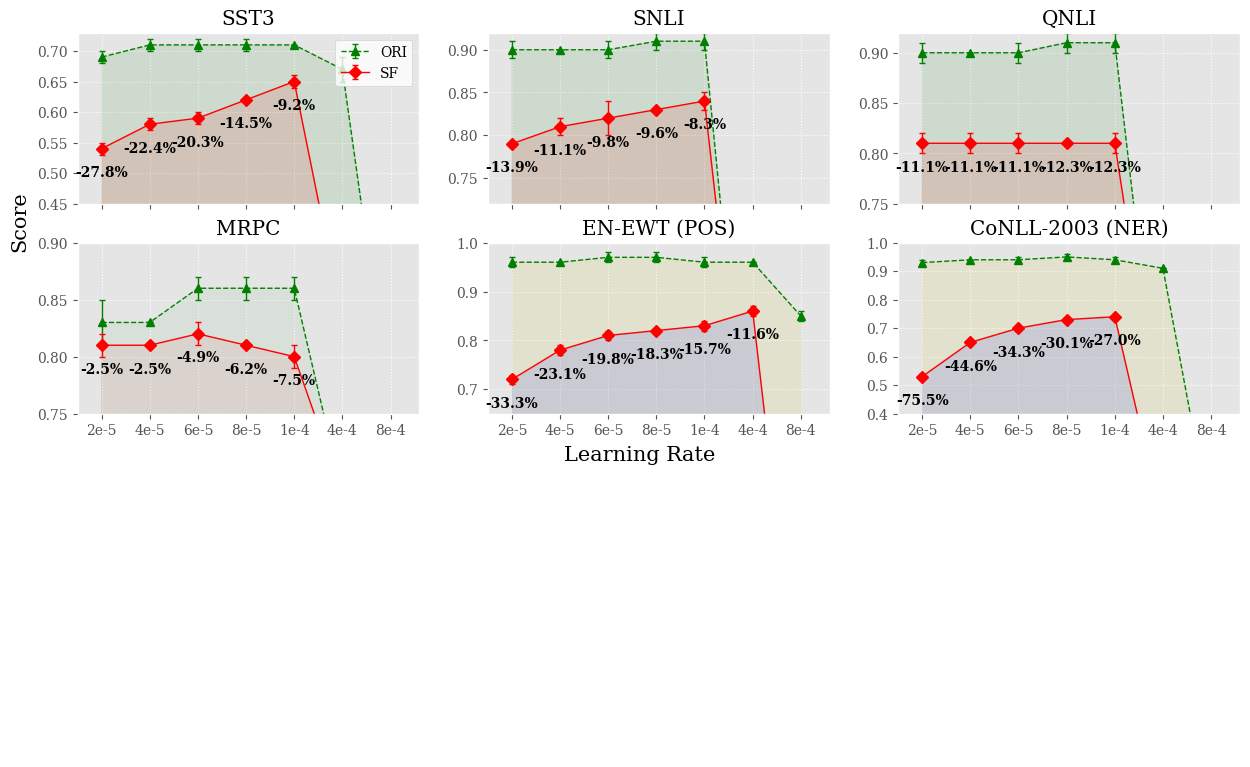

In [263]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
x_labels = ['1e-5', '2e-5', '4e-5', '6e-5', '8e-5', '1e-4', '4e-4', '8e-4', '9e-4']
x = [1,2,3,4,5,6,7]
x_ticks = [0.2,1,2,3,4,5,6,7,7.8]
for i in range(0, 2):
    for j in range(0, 3):
        axs[i, j].set_xticks(x_ticks)
        axs[i, j].set_xticklabels(x_labels)
        axs[i, j].set_xlim(0.5,7.6)
        if i == 0 and j == 0:
            task = "sst3"
            axs[i, j].title.set_text('SST3')
            axs[i, j].errorbar(x, exp_data_1["sst3_ori"], linewidth=1, yerr=[0.01,0.01,0.01,0.01,0.00,0.02,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g', label='ORI')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1["sst3_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r', label='SF')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1["sst3_ori"])):
                diss_perc = round((exp_data_1["sst3_sf"][m] - exp_data_1["sst3_ori"][m])*100/exp_data_1["sst3_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1["sst3_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.45, 0.73)
            axs[i, j].legend(facecolor="white", loc="upper right")
        elif i == 0 and j == 1:
            task = "snli"
            axs[i, j].title.set_text('SNLI')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.00,0.01,0.02,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.72, 0.92)
            
        elif i == 0 and j == 2:
            task = "qnli"
            axs[i, j].title.set_text('QNLI')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.75, 0.92)
            
        elif i == 1 and j == 0:
            task = "mrpc"
            axs[i, j].title.set_text('MRPC')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.02,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.05, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.00,0.01,0.00,0.01,0.01,0.02],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.05, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.75, 0.9)
        elif i == 1 and j == 1:
            task = "pos"
            axs[i, j].title.set_text('EN-EWT (POS)')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="y")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="b")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.65, 1.0)
            
        elif i == 1 and j == 2:
            task = "ner"
            axs[i, j].title.set_text('CoNLL-2003 (NER)')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="y")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="b")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.40, 1.0)
        # should be the last step?
        x0,x1 = axs[i, j].get_xlim()
        y0,y1 = axs[i, j].get_ylim()
        axs[i, j].set_aspect(((x1-x0)/(y1-y0))*0.5)
        if i == 0:
            axs[i, j].xaxis.set_major_formatter(plt.NullFormatter())
        axs[i, j].grid(linestyle=':')
fig.text(0.5, 0.02, 'Learning Rate', ha='center', size=15)
fig.text(0.08, 0.5, 'Score', va='center', rotation='vertical', size=15)
plt.show()

#### Actual Experiment: Order Effect

In [295]:
exp_data_1 = pd.read_csv("../data-files/order-effect.csv", delimiter=",")
exp_data_1

,snli_ori,snli_sf,qnli_ori,qnli_sf,mrpc_ori,mrpc_sf,sst3_ori,sst3_sf
0,0.75,0.74,0.60,0.61,0.70,0.71,0.61,0.62
1,0.84,0.82,0.74,0.75,0.74,0.74,0.64,0.63
2,0.89,0.85,0.85,0.84,0.76,0.76,0.66,0.64
3,0.90,0.85,0.89,0.85,0.80,0.75,0.69,0.67
4,0.90,0.86,0.90,0.86,0.82,0.74,0.69,0.68
5,0.90,0.86,0.91,0.87,0.82,0.75,0.70,0.69
6,0.90,0.86,0.91,0.87,0.83,0.75,0.71,0.70


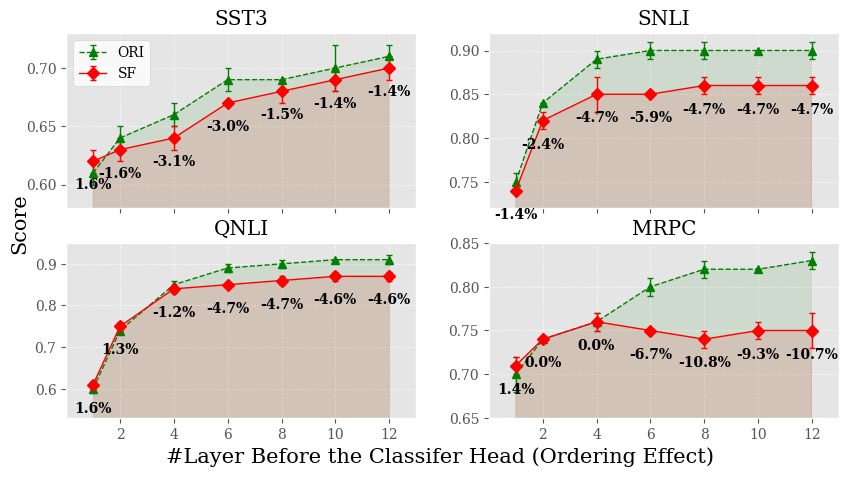

In [296]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
x_labels = [2,4,6,8,10,12]
x = [1,2,4,6,8,10,12]
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_xlim(0,13)
        axs[i, j].set_xticks(x_labels)
        if i == 0 and j == 0:
            task = "sst3"
            axs[i, j].title.set_text('SST3')
            axs[i, j].errorbar(x, exp_data_1["sst3_ori"], linewidth=1, yerr=[0.01,0.01,0.01,0.01,0.00,0.02,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g', label='ORI')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1["sst3_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r', label='SF')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1["sst3_ori"])):
                diss_perc = round((exp_data_1["sst3_sf"][m] - exp_data_1["sst3_ori"][m])*100/exp_data_1["sst3_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1["sst3_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.58, 0.73)
            axs[i, j].legend(facecolor="white", loc="upper left")
        elif i == 0 and j == 1:
            task = "snli"
            axs[i, j].title.set_text('SNLI')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.00,0.01,0.02,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.72, 0.92)
            
        elif i == 1 and j == 0:
            task = "qnli"
            axs[i, j].title.set_text('QNLI')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.53, 0.95)
            
        elif i == 1 and j == 1:
            task = "mrpc"
            axs[i, j].title.set_text('MRPC')
            axs[i, j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.02,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[i, j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.00,0.01,0.00,0.01,0.01,0.02],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[i, j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc = round((exp_data_1[f"{task}_sf"][m] - exp_data_1[f"{task}_ori"][m])*100/exp_data_1[f"{task}_sf"][m], 1)
                axs[i, j].annotate(f'{diss_perc}%', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[i, j].set_ylim(0.65, 0.85)
        # should be the last step?
        x0,x1 = axs[i, j].get_xlim()
        y0,y1 = axs[i, j].get_ylim()
        axs[i, j].set_aspect(((x1-x0)/(y1-y0))*0.5)
        if i == 0:
            axs[i, j].xaxis.set_major_formatter(plt.NullFormatter())
        axs[i, j].grid(linestyle=':')
fig.text(0.5, 0.02, '#Layer Before the Classifer Head (Ordering Effect)', ha='center', size=15)
fig.text(0.07, 0.5, 'Score', va='center', rotation='vertical', size=15)
plt.show()

#### Actual Experiment: Context-Specificity Effect

In [39]:
exp_data_1 = pd.read_csv("../data-files/context-spec-effect.csv", delimiter=",")
exp_data_1

,sst3_ori,sst3_sf,qnli_ori,qnli_sf,mrpc_ori,mrpc_sf
0,0.60,0.28,0.60,0.53,0.72,0.68
1,0.60,0.36,0.70,0.54,0.75,0.68
2,0.60,0.34,0.79,0.68,0.76,0.70
3,0.61,0.33,0.80,0.72,0.79,0.69
4,0.62,0.33,0.80,0.71,0.79,0.68
5,0.63,0.34,0.81,0.70,0.82,0.68
6,0.65,0.37,0.81,0.68,0.82,0.68


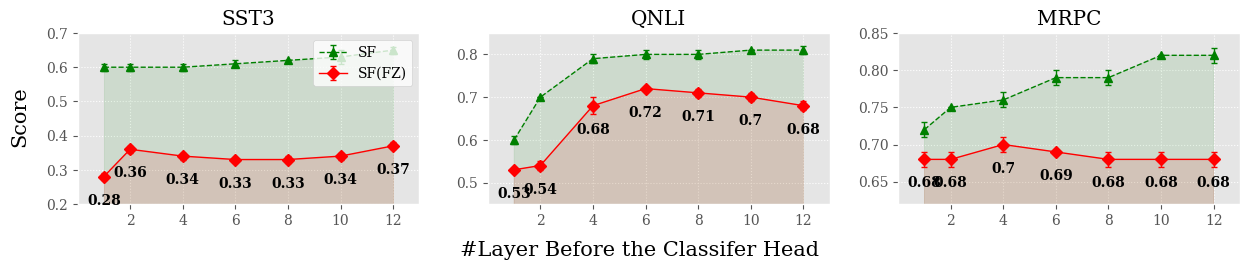

In [41]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
x_labels = ['1e-5', '2e-5', '4e-5', '6e-5', '8e-5', '1e-4', '4e-4', '8e-4', '9e-4']
x_labels = [2,4,6,8,10,12]
x = [1,2,4,6,8,10,12]
for i in range(0, 1):
    for j in range(0, 3):
        axs[j].set_xlim(0,13)
        axs[j].set_xticks(x_labels)
        if i == 0 and j == 0:
            task = "sst3"
            axs[j].title.set_text('SST3')
            axs[j].errorbar(x, exp_data_1["sst3_ori"], linewidth=1, yerr=[0.01,0.01,0.01,0.01,0.00,0.02,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g', label='SF')
            axs[j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[j].errorbar(x, exp_data_1["sst3_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r', label='SF(FZ)')
            axs[j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1["sst3_ori"])):
                diss_perc =round(exp_data_1[f"{task}_sf"][m],2)
                axs[j].annotate(f'{diss_perc}', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[j].set_ylim(0.20, 0.70)
            axs[j].legend(facecolor="white", loc="upper right")
        elif i == 0 and j == 1:
            task = "qnli"
            axs[j].title.set_text('QNLI')
            axs[j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.00,0.01,0.02,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc =round(exp_data_1[f"{task}_sf"][m],2)
                axs[j].annotate(f'{diss_perc}', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[j].set_ylim(0.45, 0.85)
            
        elif i == 0 and j == 2:
            task = "mrpc"
            axs[j].title.set_text('MRPC')
            axs[j].errorbar(x, exp_data_1[f"{task}_ori"], linewidth=1, yerr=[0.01,0.00,0.01,0.01,0.01,0.00,0.01],
                               color="green", linestyle="--", marker="^", markersize=6, 
                               capsize=2, capthick=1, ecolor='g')
            axs[j].fill_between(x, exp_data_1[f"{task}_ori"], alpha=0.1, color="g")
        
            axs[j].errorbar(x, exp_data_1[f"{task}_sf"], linewidth=1, yerr=[0.01,0.01,0.01,0.00,0.01,0.01,0.01],
                               color="red", marker="D", markersize=6, 
                               capsize=2, capthick=1, ecolor='r')
            axs[j].fill_between(x, exp_data_1[f"{task}_sf"], alpha=0.1, color="r")
            
            #annotate
            for m in range(0, len(exp_data_1[f"{task}_ori"])):
                diss_perc =round(exp_data_1[f"{task}_sf"][m],2)
                axs[j].annotate(f'{diss_perc}', xy =(x[m], exp_data_1[f"{task}_sf"][m]), 
                                   textcoords="offset points", # how to position the text
                                   xytext=(0,-20), # distance from text to points (x,y)
                                   ha='center', weight='bold')
            axs[j].set_ylim(0.62, 0.85)

        # should be the last step?
        x0,x1 = axs[j].get_xlim()
        y0,y1 = axs[j].get_ylim()
        axs[j].set_aspect(((x1-x0)/(y1-y0))*0.5)
        axs[j].grid(linestyle=':')
fig.text(0.5, 0.22, '#Layer Before the Classifer Head', ha='center', size=15)
fig.text(0.08, 0.5, 'Score', va='center', rotation='vertical', size=15)
plt.show()